In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'KOTAKBANK.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-07-02,2.402500,2.475000,2.400000,2.402500,2.223230,110800
2001-07-03,2.475000,2.475000,2.375000,2.400000,2.220916,77520
2001-07-04,2.425000,2.450000,2.387500,2.420000,2.239424,49360
2001-07-05,2.450000,2.472500,2.400000,2.415000,2.234797,62700
2001-07-06,2.425000,2.425000,2.350000,2.400000,2.220916,117800
...,...,...,...,...,...,...
2024-04-25,1665.000000,1697.800049,1602.000000,1642.449951,1642.449951,66179079
2024-04-26,1642.449951,1655.000000,1605.000000,1608.500000,1608.500000,22146849
2024-04-29,1610.099976,1647.250000,1609.500000,1640.400024,1640.400024,11227409


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
176/176 [==============================] - 16s 13ms/step - loss: 0.0049
Epoch 2/50
176/176 [==============================] - 2s 11ms/step - loss: 0.0021
Epoch 3/50
176/176 [==============================] - 2s 11ms/step - loss: 0.0018
Epoch 4/50
176/176 [==============================] - 2s 11ms/step - loss: 0.0016
Epoch 5/50
176/176 [==============================] - 2s 11ms/step - loss: 0.0015
Epoch 6/50
176/176 [==============================] - 3s 14ms/step - loss: 0.0013
Epoch 7/50
176/176 [==============================] - 2s 12ms/step - loss: 0.0014
Epoch 8/50
176/176 [==============================] - 2s 11ms/step - loss: 0.0012
Epoch 9/50
176/176 [==============================] - 2s 11ms/step - loss: 0.0011
Epoch 10/50
176/176 [==============================] - 2s 11ms/step - loss: 0.0011
Epoch 11/50
176/176 [==============================] - 2s 11ms/step - loss: 0.0011
Epoch 12/50
176/176 [==============================] - 2s 13ms/step - loss: 0.0010
Epoch 13/50


1/1 [==============================] - 0s 33ms/step


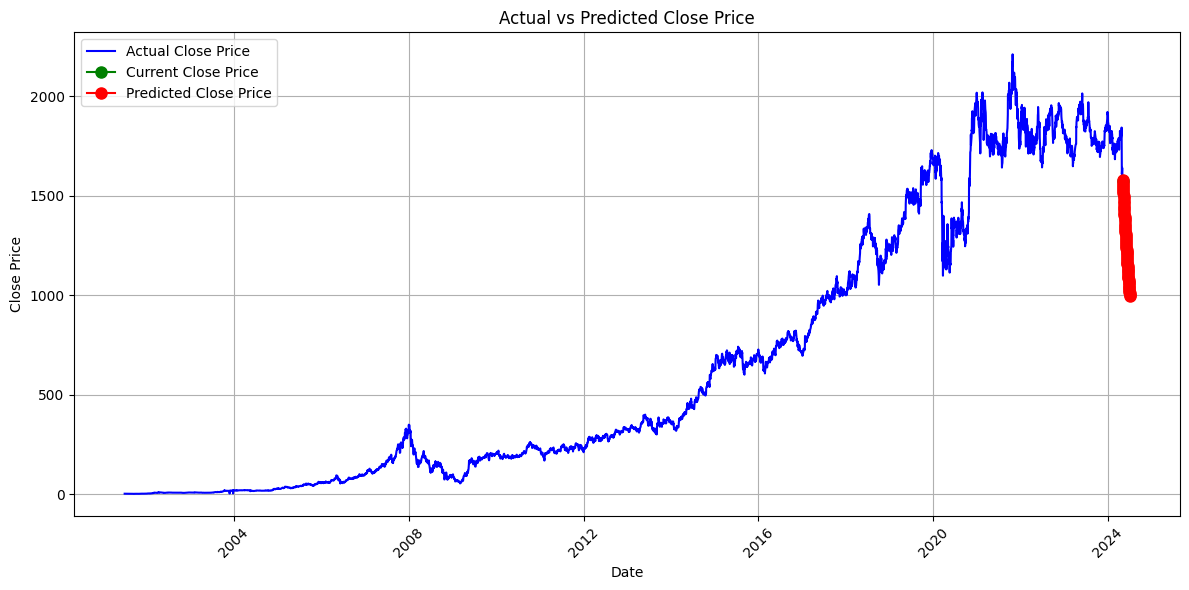

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([1579.0338 , 1564.5494 , 1554.2354 , 1545.0006 , 1535.195  ,
       1524.316  , 1512.4951 , 1500.0941 , 1487.4745 , 1474.898  ,
       1462.5122 , 1450.3735 , 1438.483  , 1426.8153 , 1415.3387 ,
       1404.026  , 1392.8574 , 1381.8206 , 1370.9078 , 1360.1151 ,
       1349.4386 , 1338.8757 , 1328.4229 , 1318.0764 , 1307.8325 ,
       1297.6875 , 1287.6371 , 1277.6781 , 1267.8069 , 1258.0204 ,
       1248.3157 , 1238.69   , 1229.1409 , 1219.666  , 1210.2633 ,
       1200.9307 , 1191.6661 , 1182.4679 , 1173.3346 , 1164.2643 ,
       1155.2556 , 1146.3074 , 1137.4181 , 1128.5865 , 1119.8118 ,
       1111.0925 , 1102.428  , 1093.8171 , 1085.2593 , 1076.7534 ,
       1068.299  , 1059.8951 , 1051.5414 , 1043.237  , 1034.9818 ,
       1026.775  , 1018.6164 , 1010.50543, 1002.4419 ,  994.4253 ],
      dtype=float32)

In [10]:
model.save('KOTAKBANK.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'KOTAKBANK.pkl')

['KOTAKBANK.pkl']